# Compare the performance of the single-task versus the MTL
The goal is to check our claim about the superiority of MTL over single task setup in terms of intrinsic ability of attenuating the effects of drop-outs.

## Load and compute prediction correlations for the single-task models

### dynamic

In [1]:
load("../scMTL_StemNet_notImputed_dynamic_singleTask.RData")
st_cors_p <- sapply(seq(length(all.test.pred)), function(i)cor(all.test.pred[[i]], partition$test$y[, i], method= "p"))
st_cors_s <- sapply(seq(length(all.test.pred)), function(i)cor(all.test.pred[[i]], partition$test$y[, i], method= "s"))

In [2]:
df <- data.frame(val= st_cors_p, feature= "dynamic", cor_method= "Pearson", model= "single-task")
df <- rbind(df, data.frame(val= st_cors_s, feature= "dynamic", cor_method= "Spearman", model= "single-task"))

### static

In [3]:
load("../scMTL_StemNet_notImputed_static_singleTask.RData")
st_cors_p <- sapply(seq(length(all.test.pred)), function(i)cor(all.test.pred[[i]], partition$test$y[, i], method= "p"))
st_cors_s <- sapply(seq(length(all.test.pred)), function(i)cor(all.test.pred[[i]], partition$test$y[, i], method= "s"))

Warning message in cor(all.test.pred[[i]], partition$test$y[, i], method = "p"):
“the standard deviation is zero”Warning message in cor(all.test.pred[[i]], partition$test$y[, i], method = "p"):
“the standard deviation is zero”Warning message in cor(all.test.pred[[i]], partition$test$y[, i], method = "s"):
“the standard deviation is zero”Warning message in cor(all.test.pred[[i]], partition$test$y[, i], method = "s"):
“the standard deviation is zero”

In [4]:
df <- rbind(df, data.frame(val= st_cors_p, feature= "static", cor_method= "Pearson", model= "single-task"))
df <- rbind(df, data.frame(val= st_cors_s, feature= "static", cor_method= "Spearman", model= "single-task"))

### epigenetic

In [5]:
load("../scMTL_StemNet_notImputed_epigenetic_singleTask.RData")
st_cors_p <- sapply(seq(length(all.test.pred)), function(i)cor(all.test.pred[[i]], partition$test$y[, i], method= "p"))
st_cors_s <- sapply(seq(length(all.test.pred)), function(i)cor(all.test.pred[[i]], partition$test$y[, i], method= "s"))

Warning message in cor(all.test.pred[[i]], partition$test$y[, i], method = "p"):
“the standard deviation is zero”Warning message in cor(all.test.pred[[i]], partition$test$y[, i], method = "p"):
“the standard deviation is zero”Warning message in cor(all.test.pred[[i]], partition$test$y[, i], method = "s"):
“the standard deviation is zero”Warning message in cor(all.test.pred[[i]], partition$test$y[, i], method = "s"):
“the standard deviation is zero”

In [6]:
df <- rbind(df, data.frame(val= st_cors_p, feature= "epigenetic", cor_method= "Pearson", model= "single-task"))
df <- rbind(df, data.frame(val= st_cors_s, feature= "epigenetic", cor_method= "Spearman", model= "single-task"))

In [7]:
head(df)
dim(df)

val,feature,cor_method,model
0.3214086,dynamic,Pearson,single-task
0.4076181,dynamic,Pearson,single-task
0.4031439,dynamic,Pearson,single-task
0.4216562,dynamic,Pearson,single-task
0.3697353,dynamic,Pearson,single-task
0.3960971,dynamic,Pearson,single-task


[1] 1482    4

## Load TGGLasso models

### dynamic

In [8]:
load("../scMTL_StemNet_notImputed_dynamic_TGGLasso.RData")
dyn_partition <- partition
dyn_tgl <- TGL.model

### static

In [9]:
load("../scMTL_StemNet_notImputed_static_TGGLasso.RData")
sta_partition <- partition
sta_tgl <- TGL.model

### epigenetic

In [10]:
load("../scMTL_StemNet_notImputed_epigenetic_TGGLasso.RData")
epi_partition <- partition
epi_tgl <- TGL.model

In [11]:
ls()

[1] "all.test.pred" "alphas"        "best.lambda"   "df"           
 [5] "dyn_partition" "dyn_tgl"       "epi_partition" "epi_tgl"      
 [9] "indiv.res"     "lambdas"       "mst"           "partition"    
[13] "pred.acc"      "st_cors_p"     "st_cors_s"     "sta_partition"
[17] "sta_tgl"       "TGL.model"

## prepare the data for the TGGLasso

In [12]:
normalize <- function(partition){
    x.train <- scale(log2(1 + partition$train$x))
    y.train <- scale(log2(1 + partition$train$y))


    x.test <- scale(log2(1 + partition$test$x), center= colMeans(log2(1 + partition$train$x)),
                    scale= apply(log2(1 + partition$train$x), 2, FUN= sd))
    y.test <- scale(log2(1 + partition$test$y), center= colMeans(log2(1 + partition$train$y)),
                    scale= apply(log2(1 + partition$train$y), 2, FUN= sd))
    return(list(x.train= x.train, y.train= y.train, x.test= x.test, y.test= y.test))
}

In [13]:
get_pred_cors <- function(data, TGL.model){
    x.train <- data$x.train
    x.test <- data$x.test
    y.train <- data$y.train
    y.test <- data$y.test
    pred.train <- cbind(1, x.train) %*% rbind(TGL.model$intercept, TGL.model$B)
    pred.test <- cbind(1, x.test) %*% rbind(TGL.model$intercept, TGL.model$B)
    options(warn= -1)
    # Train
    ## Method= Pearson
    cors.train.p <- sapply(seq(ncol(pred.train)), function(i)
        cor(pred.train[, i], y.train[, i], method= "pearson"))

    ## Method= Spearman
    cors.train.s <- sapply(seq(ncol(pred.train)), function(i)
        cor(pred.train[, i], y.train[, i], method= "spearman"))

    # Test
    ## Method= Pearson
    cors.test.p <- sapply(seq(ncol(pred.test)), function(i)
        cor(pred.test[, i], y.test[, i], method= "pearson"))

    ## Method= Spearman
    cors.test.s <- sapply(seq(ncol(pred.test)), function(i)
    cor(pred.test[, i], y.test[, i], method= "spearman"))
    return(list(cors.train.p= cors.train.p, cors.train.s= cors.train.s,
                cors.test.p= cors.test.p, cors.test.s= cors.test.s))
}

In [14]:
get_cor_df <- function(data, TGL.model, feature_type){
    cors <- get_pred_cors(data, TGL.model)
    
    df <- data.frame(val= cors$cors.test.p, feature= feature_type,
                     cor_method= "Pearson", model= "TGGLasso")
    df <- rbind(df, data.frame(val= cors$cors.test.s, feature= feature_type,
                     cor_method= "Spearman", model= "TGGLasso"))
    return(df)
}

In [15]:
dyn_data <- normalize(dyn_partition)
sta_data <- normalize(sta_partition)
epi_data <- normalize(epi_partition)

In [16]:
print(nrow(get_cor_df(dyn_data, dyn_tgl, "dynamic")))
print(nrow(get_cor_df(dyn_data, dyn_tgl, "static")))
print(nrow(get_cor_df(dyn_data, dyn_tgl, "epigenetic")))

[1] 494
[1] 494
[1] 494


In [17]:
df <- rbind(df, get_cor_df(dyn_data, dyn_tgl, "dynamic"))
df <- rbind(df, get_cor_df(sta_data, sta_tgl, "static"))
df <- rbind(df, get_cor_df(epi_data, epi_tgl, "epigenetic"))

In [18]:
dim(df)

[1] 2964    4

In [19]:
df2 <- data.frame(single_task= subset(df, model == "single-task")$val, TGGLasso= subset(df, model == "TGGLasso")$val,
                 subset(df, model == "single-task")[, -1, drop= F])

In [20]:
head(df2)
dim(df2)

single_task,TGGLasso,feature,cor_method,model
0.3214086,0.3428559,dynamic,Pearson,single-task
0.4076181,0.4325126,dynamic,Pearson,single-task
0.4031439,0.4249071,dynamic,Pearson,single-task
0.4216562,0.4372364,dynamic,Pearson,single-task
0.3697353,0.3922108,dynamic,Pearson,single-task
0.3960971,0.4147380,dynamic,Pearson,single-task


[1] 1482    5

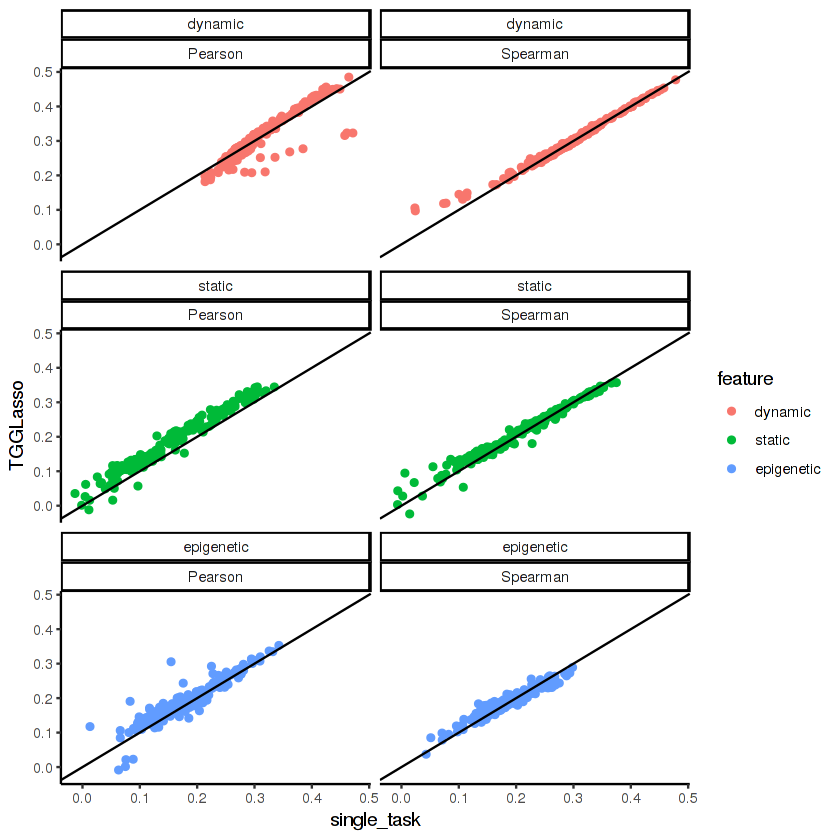

In [21]:
library(ggplot2)
ggplot() + geom_point(df2, mapping= aes(x= single_task, y= TGGLasso, color= feature)) +
geom_abline(slope= 1, interface= 0) +
facet_wrap(c("feature", "cor_method") , ncol= 2) + 
theme_classic()

## Compute the ratio of cells where single-task was better than TGGLasso

In [22]:
feature_df <- subset(df2, feature == "epigenetic")
cat("epigenetic features")
length(which(feature_df$single_task > feature_df$TGGLasso)) / nrow(feature_df)

feature_df <- subset(df2, feature == "static")
cat("static features")
length(which(feature_df$single_task > feature_df$TGGLasso)) / nrow(feature_df)

feature_df <- subset(df2, feature == "dynamic")
cat("dynamic features")
length(which(feature_df$single_task > feature_df$TGGLasso)) / nrow(feature_df)

epigenetic features

[1] 0.3036437

static features

[1] 0.1255061

dynamic features

[1] 0.4352227

# Conclusion
The aim of this notebook was to compare how the prediction correlations (test data only) differ between the single-task and TGGLasso models, trained on **not-imputed** data, and test whether the multi-task learning approach (TGGLasso) that shares the information accros the cells would help evading the affect of dropouts. This type of analysis suggests the following points:

* similar to the HSMM (human myoblast) dataset, the TGGLasso model trained on the static features outperforms the single-task ones.
* When considering the correlation methods, it seems like that the Spearman correlation is less sensitive to the type of model generating the predictions (TGGLasso or single-task).
* The models trained on the dynamic and epigenetic features tend to have the highest ratio of cells with single-task models outperforming the TGGLasso ones with all of them being still less than 50%.
* Given the point above, we can indeed claim that the MTL approach is better than single-task and that it does get around the dropout issue implicitly.